### Load libraries

In [2]:
import io
import requests
import re
import warnings
import os

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

### 1) Pre-process the datset

In [3]:
# Load the dataset
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
combine = [train_df, test_df]

In [4]:
# dropping features
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print("After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before (891, 12) (418, 11) (891, 12) (418, 11)
After (891, 10) (418, 9) (891, 10) (418, 9)


In [5]:
# creating new features from existing
# Name -> Title
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
print(train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

# dropping the Name and PassengerId features
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

train_df.head()

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,3
2,1,3,female,26.0,0,0,7.9250,S,2
3,1,1,female,35.0,1,0,53.1000,S,3
4,0,3,male,35.0,0,0,8.0500,S,1


In [6]:
test_df['Pclass'].isna().sum()

0

In [7]:
# Quick completing and converting a numeric features
   
# Embarked
## Completing Embarked by filling na values by the most frequent value
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

# Fare
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

In [8]:
# Converting categorical features to numerical
# Sex and embarked
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
train_df.head(2)
    

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,0,1
1,1,1,1,38.0,1,0,71.2833,1,3


In [9]:
# Completing Age feature
# Age
guess_ages = np.zeros((2,3))
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

In [10]:
# Simplifying existing features
# Age -> Agebands -> Age

train_df['AgeBand'] = pd.cut(train_df['Age'], 4)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 18, 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 35), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 35) & (dataset['Age'] <= 60), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 60, 'Age'] = 4

# # FareBand
# train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
# for dataset in combine:
#     dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
#     dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
#     dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
#     dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
#     dataset['Fare'] = dataset['Fare'].astype(int)

# we can now drop the AgeBand and FareBand features
train_df = train_df.drop(['AgeBand'], axis=1)
# train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,2,1,0,7.2500,0,1
1,1,1,1,3,1,0,71.2833,1,3
2,1,3,1,2,0,0,7.9250,0,2
3,1,1,1,2,1,0,53.1000,0,3
4,0,3,0,2,0,0,8.0500,0,1


In [11]:
# Creating new feature from existing ones
# FamilySize
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

print(train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False))

# IsAlone
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

print(train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

# Age*Class
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass



# # we can now drop Parch, FamilySize and SibSp in favour of IsAlone
# train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
# test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)

# # we can now drop Parch and SibSp in favour of FamilySize
train_df = train_df.drop(['Parch', 'SibSp'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp'], axis=1)
combine = [train_df, test_df]

train_df.head(2)

   FamilySize  Survived
3           4  0.724138
2           3  0.578431
1           2  0.552795
6           7  0.333333
0           1  0.303538
4           5  0.200000
5           6  0.136364
7           8  0.000000
8          11  0.000000
   IsAlone  Survived
0        0  0.505650
1        1  0.303538


,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,IsAlone,Age*Class
0,0,3,0,2,7.2500,0,1,2,0,6
1,1,1,1,3,71.2833,1,3,2,0,3


In [12]:
train_df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title',
       'FamilySize', 'IsAlone', 'Age*Class'],
      dtype='object')

In [13]:
drop_features = ['Age*Class', 'FamilySize']

train_df = train_df.drop(drop_features, axis=1)
test_df = test_df.drop(drop_features, axis=1)

combine = [train_df, test_df]

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(train_df.drop("Survived", axis=1), train_df["Survived"], test_size=0.2)

In [15]:
# Model, predict, solve

# X_train = train_df.drop("Survived", axis=1)
# Y_train = train_df["Survived"]
# X_test  = test_df.drop("PassengerId", axis=1).copy()
# print(f'{X_train.shape = }, {Y_train.shape = }, {X_test.shape = }')

### Learn and fine-tune a decision tree model with the Titanic training data

In [17]:
# Decision Tree

max_depth_values = np.arange(1, 100+1, 1)
min_samples_split_values = np.arange(2, 100+1, 1)
best_max_depth = 0
best_samples_split = 0
best_accuracy = 0

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        decision_tree = DecisionTreeClassifier(min_samples_split=min_samples_split, max_depth=max_depth)
        decision_tree.fit(X_train, Y_train)
        Y_pred = decision_tree.predict(X_test)
        acc_decision_tree = round(metrics.accuracy_score(Y_pred, Y_test) * 100, 2)

        if acc_decision_tree > best_accuracy:
            best_accuracy = acc_decision_tree
            best_max_depth = max_depth
            best_samples_split = min_samples_split

        print(f'{max_depth = }, {min_samples_split = }, {acc_decision_tree = }, {best_max_depth = }, {best_samples_split = }, {best_accuracy = }', end='\r')


In [23]:
decision_tree = DecisionTreeClassifier(min_samples_split=best_samples_split, max_depth=best_max_depth)
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(metrics.accuracy_score(Y_pred, Y_test) * 100, 2)
print(f'Decision Tree accuracy = {acc_decision_tree}%')

Decision Tree accuracy = 85.47%


### Plot decision tree

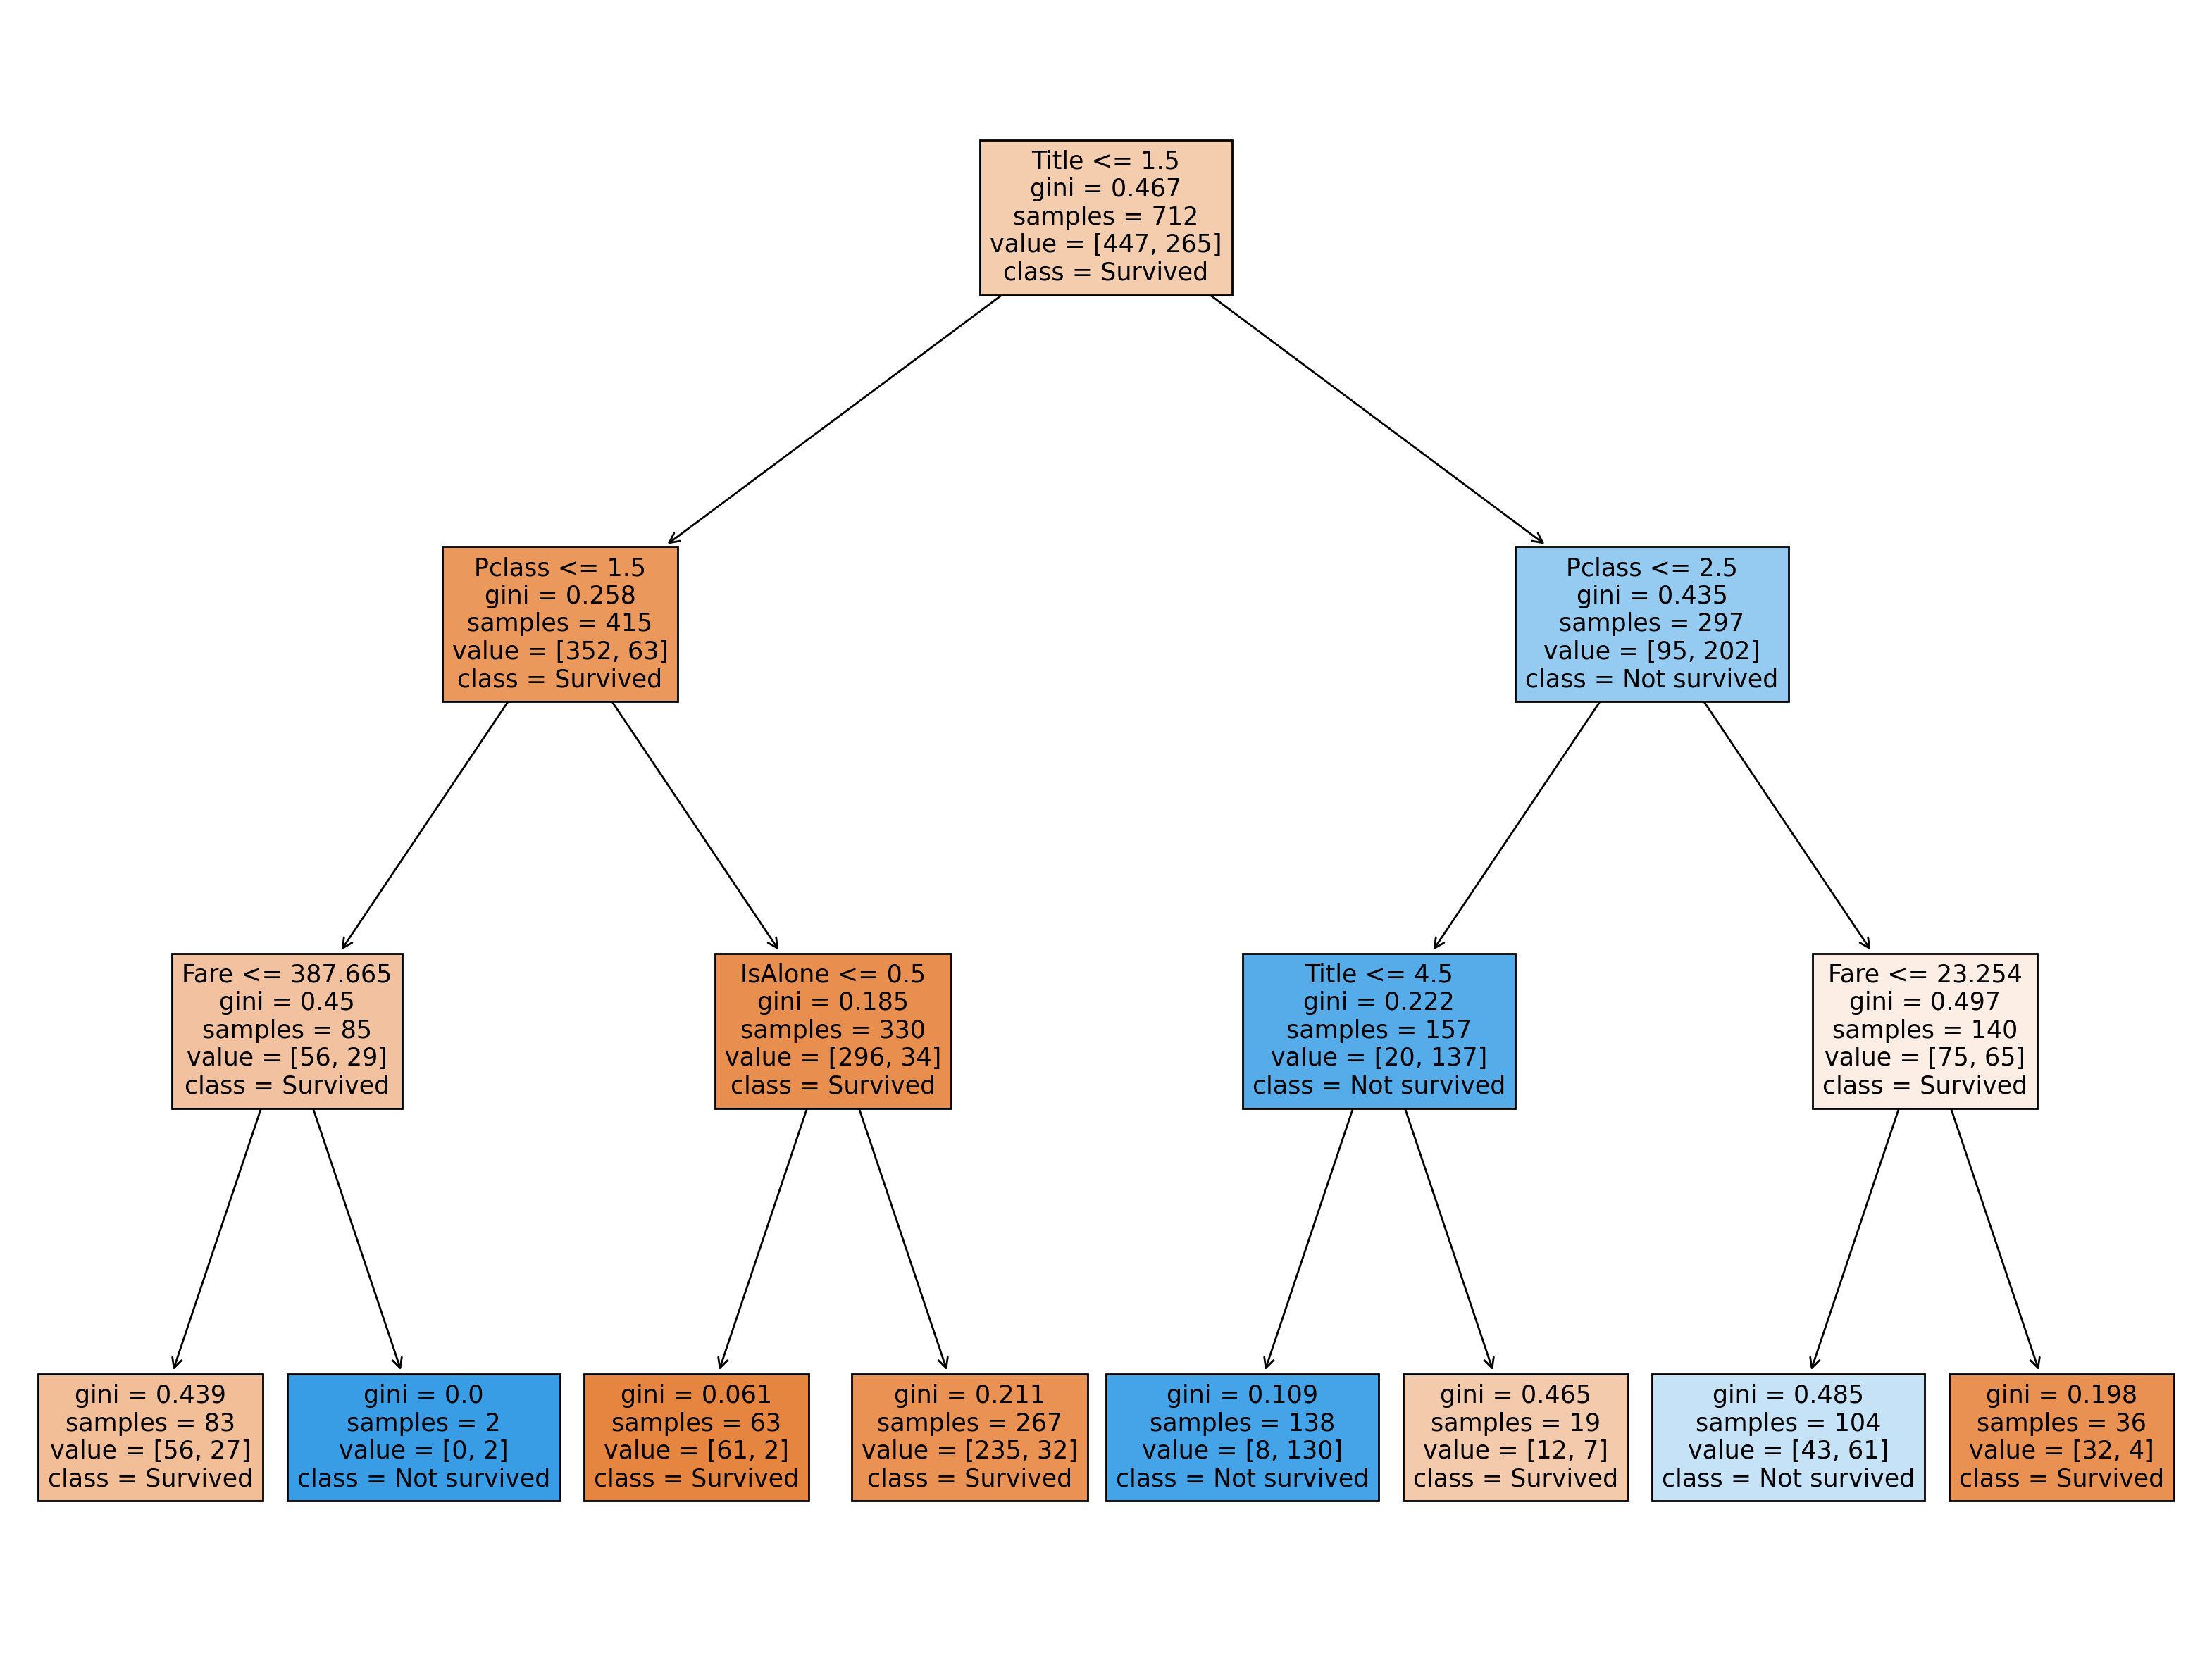

In [20]:
from sklearn import tree
fig = plt.figure(figsize=(20,15), dpi=200)
_ = tree.plot_tree(decision_tree, 
                   feature_names=X_train.columns,  
                   class_names=['Survived', 'Not survived'],
                   filled=True)

In [21]:
fig.savefig('tree.png')

In [25]:
# Random Forest
top_accuracy = 0
top_value_x = 0
top_value_y = 0

for value_x in np.arange(1, 100+1, 1):
    for value_y in np.arange(1, 100+1, 1):
        # for i in range(50):
        # Random Forest Classifier
        random_forest = RandomForestClassifier(n_estimators=value_x, 
                                            criterion='gini',
                                            max_depth=value_y)

        random_forest.fit(X_train, Y_train)
        Y_pred = random_forest.predict(X_test)
        random_forest.score(X_train, Y_train)   
        acc_random_forest = round(metrics.accuracy_score(Y_pred, Y_test) * 100, 2)
        if acc_random_forest > top_accuracy:
            top_accuracy = acc_random_forest
            top_value_x = value_x
            top_value_y = value_y
        
        print(f'{value_x = }, {value_y = }, {i = }, {acc_random_forest = }, {top_value_x = }, {top_value_y = }, {top_accuracy = }', end='\r')


In [29]:
# Random Forest Classifier
acc_random_forest = 0
while acc_random_forest < 88:
    random_forest = RandomForestClassifier(n_estimators=6, 
                                        criterion='gini',
                                        max_depth=5)

    random_forest.fit(X_train, Y_train)
    Y_pred = random_forest.predict(X_test)
    random_forest.score(X_train, Y_train)   
    acc_random_forest = round(metrics.accuracy_score(Y_pred, Y_test) * 100, 2)

    print(f'{acc_random_forest=}', end='\r')

print(f'Random Forest accuracy = {acc_random_forest}%')

Random Forest accuracy = 88.27%


### Decision Tree five-fold cross validation

In [32]:
# K-Fold Cross-Validation
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

decision_tree_result = cross_validation(decision_tree, X_test, Y_test, 5)              
decision_tree_result

{'Training Accuracy scores': array([0.83916084, 0.84615385, 0.86713287, 0.86713287, 0.84027778]),
 'Mean Training Accuracy': 85.19716394716396,
 'Training Precision scores': array([0.93333333, 0.82258065, 0.81818182, 0.90384615, 0.79104478]),
 'Mean Training Precision': 0.8537973453283998,
 'Training Recall scores': array([0.67741935, 0.82258065, 0.8852459 , 0.7704918 , 0.85483871]),
 'Mean Training Recall': 0.8021152829190903,
 'Training F1 scores': array([0.78504673, 0.82258065, 0.8503937 , 0.83185841, 0.82170543]),
 'Mean Training F1 Score': 0.8223169816713778,
 'Validation Accuracy scores': array([0.86111111, 0.77777778, 0.69444444, 0.80555556, 0.77142857]),
 'Mean Validation Accuracy': 78.20634920634919,
 'Validation Precision scores': array([0.91666667, 0.76923077, 0.69230769, 0.90909091, 0.68421053]),
 'Mean Validation Precision': 0.7943013127223654,
 'Validation Recall scores': array([0.73333333, 0.66666667, 0.5625    , 0.625     , 0.86666667]),
 'Mean Validation Recall': 0.690

### Random Forest five cross validation

In [33]:
random_forest_result = cross_validation(random_forest, X_test, Y_test, 5)              
random_forest_result

{'Training Accuracy scores': array([0.83916084, 0.92307692, 0.93006993, 0.88811189, 0.86805556]),
 'Mean Training Accuracy': 88.96950271950273,
 'Training Precision scores': array([0.86792453, 0.93220339, 0.93220339, 0.94117647, 0.84126984]),
 'Mean Training Precision': 0.902955523964196,
 'Training Recall scores': array([0.74193548, 0.88709677, 0.90163934, 0.78688525, 0.85483871]),
 'Mean Training Recall': 0.8344791115811739,
 'Training F1 scores': array([0.8       , 0.90909091, 0.91666667, 0.85714286, 0.848     ]),
 'Mean Training F1 Score': 0.8661800865800867,
 'Validation Accuracy scores': array([0.86111111, 0.77777778, 0.75      , 0.83333333, 0.88571429]),
 'Mean Validation Accuracy': 82.15873015873015,
 'Validation Precision scores': array([0.77777778, 0.76923077, 0.76923077, 1.        , 0.92307692]),
 'Mean Validation Precision': 0.8478632478632478,
 'Validation Recall scores': array([0.93333333, 0.66666667, 0.625     , 0.625     , 0.8       ]),
 'Mean Validation Recall': 0.7300

### Best model?

It is obvious that Random Forest is the better model as it benefits from ensembling multiple decision trees. The fine tuning process is iterative because Random Forest gives a different accuracy score every time a new model is created unlike the robust decision tree model. This allows different accuracy scores for the same hyper-parameters